#FOREST FIRE PREDICTION

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [33]:
df=pd.read_csv("D:/Datasets/forestfires.csv")
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
None
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900

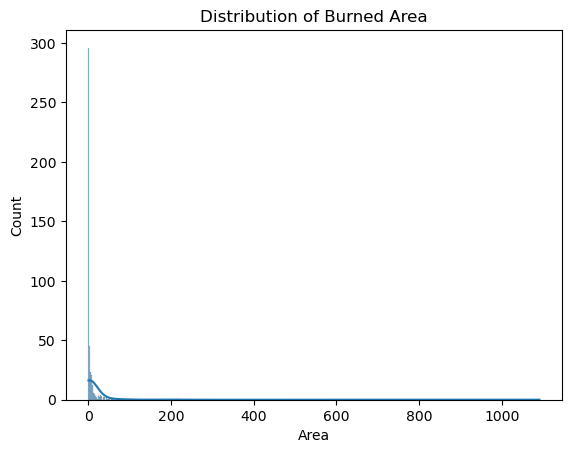

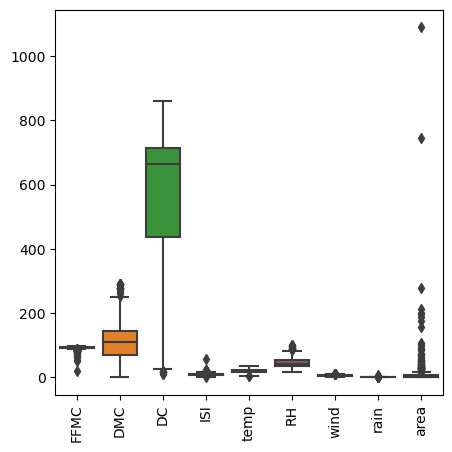

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of the target variable 'area'
sns.histplot(df['area'], kde=True)
plt.xlabel('Area')
plt.title('Distribution of Burned Area')
plt.show()

# Boxplot to detect outliers in continuous variables
plt.figure(figsize=(5,5))
sns.boxplot(data=df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']])
plt.xticks(rotation=90)
plt.show()


In [8]:
#FEATURE ENGINEERING
from sklearn.preprocessing import LabelEncoder

# Convert categorical variables to numerical
df['month'] = LabelEncoder().fit_transform(df['month'])
df['day'] = LabelEncoder().fit_transform(df['day'])

# Feature interaction: Creating a new feature (e.g., temp * wind)
df['temp_wind'] = df['temp'] * df['wind']

# Log transformation to handle skewness in 'area'
df['log_area'] = np.log1p(df['area'])

# Feature selection: Dropping the original 'area' column
X = df.drop(columns=['area', 'log_area'])
y = df['log_area']


In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)


Random Forest RMSE: 1.4973093868305367, R²: -0.020053049760114794
Linear Regression RMSE: 1.497621472714259, R²: -0.020478315689379967


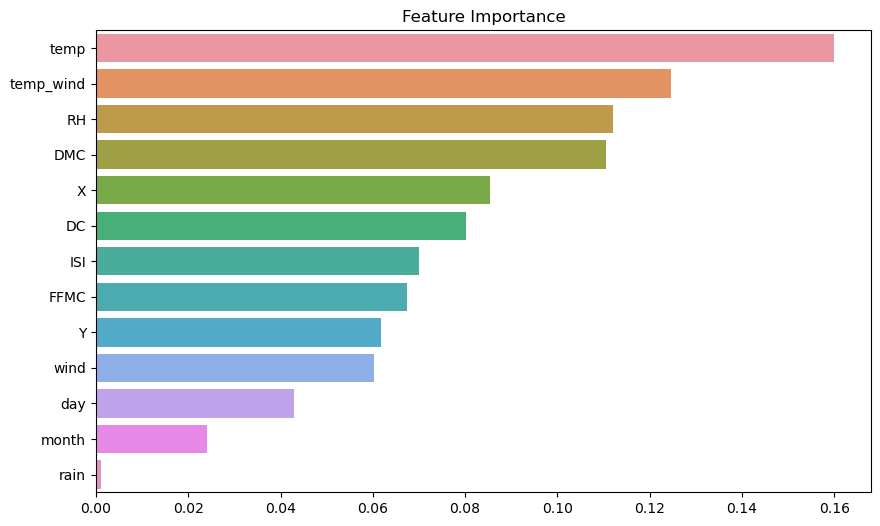

In [35]:
# improving model performance by handling multicollinearity
# Step 2: Handle Missing or Infinite Values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Step 3: Convert Categorical Data to Numerical
df['month'] = df['month'].astype('category').cat.codes
df['day'] = df['day'].astype('category').cat.codes

# Separate features and target
X = df.drop(columns=['area'])
y = df['area']

# Ensure all features are numerical
if X.select_dtypes(include=['object']).shape[1] > 0:
    raise ValueError("DataFrame contains non-numeric columns")

# Step 4: Calculate VIF for Each Feature
def calculate_vif(X):
    try:
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        return vif_data
    except Exception as e:
        print("Error calculating VIF:", e)
        return pd.DataFrame()

def remove_high_vif_features(X, vif_data, threshold=5.0):
    while not vif_data.empty and vif_data["VIF"].max() > threshold:
        feature_to_remove = vif_data.sort_values("VIF", ascending=False).iloc[0]["feature"]
        X = X.drop(columns=[feature_to_remove])
        vif_data = calculate_vif(X)
        if vif_data.empty or X.shape[1] == 0:
            break
    return X

vif_data = calculate_vif(X)
if vif_data is not None:
    print("Initial VIF Data:\n", vif_data)
    
    # Remove features with high VIF iteratively
    X = remove_high_vif_features(X, vif_data)

    # Check if there are enough features left
    if X.shape[1] == 0:
        raise ValueError("After removing features with high VIF, no valid features remain in the dataset.")

# Step 5: Check for Zero Samples
if X.shape[0] == 0:
    raise ValueError("No samples left after removing features.")

# Step 6: Split the Data
test_size = 0.2
if X.shape[0] < 2 / test_size:
    test_size = max(0.1, X.shape[0] / 2 - 1)  # Ensure the test size is reasonable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Step 7: Normalize/Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 8: Train Models

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_predictions = lr_model.predict(X_test_scaled)

# Random Forest with Default Parameters
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

# Step 9: Evaluate Models
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")

# Evaluate Linear Regression
print("Linear Regression:")
evaluate_model(y_test, lr_predictions)

# Evaluate Random Forest
print("Random Forest:")
evaluate_model(y_test, rf_predictions)


Initial VIF Data:
    feature        VIF
0        X   7.279439
1        Y  18.666162
2    month   4.006719
3      day   3.182171
4     FFMC  73.568338
5      DMC  10.115355
6       DC  16.291284
7      ISI   6.638552
8     temp  29.465414
9       RH  12.337224
10    wind   6.697805
11    rain   1.043116
Linear Regression:
RMSE: 108.9009733903467
R²: -0.00607917634586852
Random Forest:
RMSE: 106.75900432438758
R²: 0.03310866917561617
